In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import sys
import os
import numpy as np
import pandas as pd
import scipy.sparse
from scipy.sparse import csc_matrix
from scipy.sparse import lil_matrix

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Circle
import seaborn as sns; 
from IPython.display import HTML

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import svm
from sklearn.metrics import r2_score

In [3]:
#config parser
import configparser

sys.path.insert(0, '../Common/')
from AISDataManager import AISDataManager
import Constants as c
import HMUtils as hMUtil
import TimeUtils as timeUtils
import GeoCompute as gC

#MyConfig.INI stores all the run time constants
config = configparser.ConfigParser()
config.read('../MyConfig.INI')

from joblib import Parallel, delayed
import multiprocessing
aISDM = AISDataManager()
numCores = multiprocessing.cpu_count()

In [4]:
lonMin = (float)(config['TP_SEC_ORDER']['LON_MIN'])
lonMax = (float)(config['TP_SEC_ORDER']['LON_MAX'])

latMin = (float)(config['TP_SEC_ORDER']['LAT_MIN'])
latMax = (float)(config['TP_SEC_ORDER']['LAT_MAX'])

print(lonMin,latMin)
print(lonMax,latMax)

increStep = (float)(config['TP_SEC_ORDER']['INCR_STEP'])
incrRes = (int)(config['TP_SEC_ORDER']['INCR_RES'])

fileDir = config['TP_SEC_ORDER']['SOURCE_DIR']
dirToStore = config['TP_SEC_ORDER']['DEST_DIR']

print("SOURCE_DIR = %s"%fileDir)
print("DEST_DIR = %s"%dirToStore)

-120.5 33.9
-119.0 34.44
SOURCE_DIR = ../Data/M120_50_M119_00_33_90_34_44/Container/
DEST_DIR = ../Data/M120_50_M119_00_33_90_34_44/Container/SparseTP/


In [5]:
heatMapGrid = hMUtil.generate_grid(lonMin, lonMax, latMin, latMax, increStep, incrRes)

In [6]:
boundaryArray = heatMapGrid[2]
horizontalAxis = heatMapGrid[0]
verticalAxis = heatMapGrid[1]
totalStates = horizontalAxis.shape[0] * verticalAxis.shape[0]

In [7]:
def get_index_from_lon_lat(lon,lat):
    retVal = -1
    for boundary in boundaryArray: 
        if(lon >= boundary[0]) and (lon < boundary[1]) \
            and (lat >= boundary[2]) and (lat < boundary[3]):
            retVal = boundary[4]
            break 
    return retVal

In [8]:
opFile = dirToStore + 'TPM.npz'
# opFile = dirToStore + 'TPM_.npz'
tpMatrix = scipy.sparse.load_npz(opFile)

# opFile = dirToStore + 'TPM.npy'
# tpMatrix = np.load(opFile)

In [9]:
def get_vessel_init_status(lonStart,latStart):
    vesselState = np.zeros((horizontalAxis.shape[0]*verticalAxis.shape[0]))
    for boundary in boundaryArray :
        if((lonStart >= boundary[0]) \
            and (lonStart < boundary[1]) \
           
            and (latStart >= boundary[2]) \
            and (latStart < boundary[3]) \
          ):
            vesselState[boundary[4]] = 1.0
            break
    return vesselState

#takes inital state vector
#and number of steps 
#uses transition probabilities to generate the path
def generate_path(vesselStatus):
    return (vesselStatus.T @ tpMatrix).flatten()

def generate_vessel_prev_cur_status(prevState,currState):
    vesselState = np.zeros((totalStates*totalStates))
    stateCounter = 0
    for i in range(prevState.shape[0]):
        for j in range(currState.shape[0]):
            vesselState[stateCounter] = prevState[i]*currState[j]
            stateCounter = stateCounter + 1
    return vesselState

In [10]:
usefulList = [100, 300, 400, 500, 600, 700, 900, 1000, 1100, 1200, 1400, 1600 \
              , 2100, 2400, 2500, 2700, 2800, 3000, 3100, 3400, 3600, 3700 \
              , 4100, 4300, 4400, 4600, 4700, 4800, 4900, 5100, 5200, 5500 \
              , 5600, 5700, 5900, 6000, 6100, 6300, 6500, 6600, 6800, 7000 \
              , 7400, 7600, 7700, 7800, 7900, 8000, 8200, 8300, 8400, 8500 \
              , 8600, 8700, 8800, 9100, 9300, 10000, 10100, 10400, 10500, 10700 \
              , 10800, 10900, 11000, 11100, 11200, 11300, 11400, 11500, 11600, 11700 \
              , 11800, 11900, 12000, 12100, 12400, 12500, 12600, 12700, 13200, 13300 \
              , 13400, 13500, 13700, 13800, 13900, 14000, 14100, 14200, 14300, 14400 \
              , 14500, 14600, 14700, 14800, 14900, 15000, 15300, 15500, 15700, 15900 \
              , 16100, 16200, 16400, 16500, 16700, 16800, 16900, 17100, 17200, 17500 \
              , 17600, 17900, 18000, 18300, 18500, 18600, 19300, 19400, 19500, 19600 \
              , 19700, 19900, 20000, 20100, 20400, 20500, 20600, 20700, 20800, 21000 \
              , 21100, 21200, 21300, 21400, 21500, 21800, 21900, 22000, 22100, 22200 \
              , 22300, 22400, 22500, 22900, 23000, 23200, 23300, 23500, 23700, 24100 \
              , 24200, 24300, 24400, 24600, 24700, 24800, 24900, 25000, 25100, 25200 \
              , 25300, 25400, 25500, 25800, 25900, 26000, 26200, 26300, 26400, 26500 \
              , 26600, 26900, 27000, 27300, 27400, 27500, 27600, 30000, 30100, 30600 \
              , 30700, 31000, 31200, 31900, 32200, 32300, 32500, 32700, 32800, 33100 \
              , 33200, 33300, 33400, 33500, 33600, 33700, 34100, 34200, 34300, 34400 \
              , 34500, 34700, 34800, 35000, 35100, 35300, 35500, 35600, 35800, 36100 \
              , 36400, 36500, 36700, 36800, 37000, 37100, 37200, 37300, 37400, 37500 \
              , 37900, 38000, 38100, 38400, 38500, 38800, 39000, 39200, 39300, 39500 \
              , 40000, 40300, 40400, 40600, 40900, 41100, 41200, 41300, 41400, 41500 \
              , 41600, 41700, 41900, 42000, 42100, 42200, 42300, 42400, 42500, 42600 \
              , 42700, 42800, 42900, 43000, 43100, 43200, 43300, 43400, 43500, 43600 \
              , 43700, 43800, 43900, 44000, 44100, 44200, 44300, 44400, 44500, 44600 \
              , 44900, 45000, 45100, 45200, 45300, 45400, 45500, 45900, 46000, 46100 \
              , 46200, 46300, 46400, 46500, 46800, 46900, 47000, 47200, 47300, 47400 \
              , 47600, 47700, 47800, 47900, 48000, 48100, 48200, 48300, 48400, 48500 \
              , 48600, 48700, 48800, 48900, 49000, 49100, 49200, 49400, 49600, 49700 \
              , 49800, 49900, 50000, 50100, 50200, 50300, 50400, 50500, 50600, 50700 \
              , 50800, 50900, 51000, 51100, 51200, 51300, 51400, 51500, 51600, 51700 \
              , 51800, 51900, 52000, 52100, 52200, 52500, 53100, 53200, 53500, 53600 \
              , 53700, 53900, 54300, 54500, 54800, 54900, 55100, 55300, 55400, 55600 \
              , 55800, 56100, 56300, 56800, 57100, 57400, 57600, 57900, 58000, 58100 \
              , 58200, 58300, 58400, 58500, 58900, 59000, 59100, 59600, 59700, 59800 \
              , 59900]

In [11]:
usefulList = [100, 300, 400, 500, 600, 700, 900, 1000, 1100, 1200, 1400, 1600 \
              , 2100, 2400, 2500, 2700, 2800, 3000, 3100, 3400, 3600, 3700 \
              , 4100, 4300, 4400, 4600, 4700, 4800, 4900, 5100, 5200, 5500 \
              , 5600, 5700, 5900, 6000, 6100, 6300, 6500, 6600, 6800, 7000 \
              , 7400, 7600, 7700, 7800, 7900, 8000, 8200, 8300, 8400, 8500 \
              , 8600, 8700, 8800, 9100, 9300, 10000, 10100, 10400, 10500, 10700 \
              , 10800, 10900, 11000, 11100, 11200, 11300, 11400, 11500, 11600, 11700 \
              , 11800, 11900, 12000, 12100, 12400, 12500, 12600, 12700, 13200, 13300 \
             ]

In [12]:
rowSum = np.sum(tpMatrix, axis=1)
rowSumZeroIdx = np.argwhere(rowSum == 0)
rowSumZeroIdx = rowSumZeroIdx.flatten()

KeyboardInterrupt: 

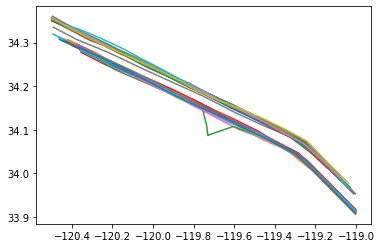

In [13]:
errorVal30_1 = []
errorVal30_2 = []
errorVal30_3 = []
errorVal30_4 = []
errorVal30_5 = []

errorVal60_1 = []
errorVal60_2 = []
errorVal60_3 = []
errorVal60_4 = []
errorVal60_5 = []

errorVal90_1 = []
errorVal90_2 = []
errorVal90_3 = []
errorVal90_4 = []
errorVal90_5 = []

errorVal120_1 = []
errorVal120_2 = []
errorVal120_3 = []
errorVal120_4 = []
errorVal120_5 = []

errorVal150_1 = []
errorVal150_2 = []
errorVal150_3 = []
errorVal150_4 = []
errorVal150_5 = []

errorVal180_1 = []
errorVal180_2 = []
errorVal180_3 = []
errorVal180_4 = []
errorVal180_5 = []

errorVal210_1 = []
errorVal210_2 = []
errorVal210_3 = []
errorVal210_4 = []
errorVal210_5 = []

errorVal240_1 = []
errorVal240_2 = []
errorVal240_3 = []
errorVal240_4 = []
errorVal240_5 = []

for lEFileNum in usefulList:
    oneVessel = "../Data/M120_50_M119_00_33_90_34_44/MMSIContainer/"+str(lEFileNum)+".csv"
    oneVesselLastData,_ = aISDM.load_data_from_csv(oneVessel)
    oneVesselLastDataLon = oneVesselLastData["LON"]
    oneVesselLastDataLat = oneVesselLastData["LAT"]
    plt.plot(oneVesselLastDataLon,oneVesselLastDataLat)

    vesselPrevState = get_vessel_init_status(oneVesselLastDataLon.iloc[0],oneVesselLastDataLat.iloc[0])
    vesselCurrState = get_vessel_init_status(oneVesselLastDataLon.iloc[1],oneVesselLastDataLat.iloc[1])
    vesselState = generate_vessel_prev_cur_status(vesselPrevState,vesselCurrState)
    
    onePredict = []
    for i in range(8):
        vesselProbState = generate_path(vesselState)
        onePredict.append(vesselProbState.copy())
        vesselPrevState = vesselCurrState.copy()
        vesselCurrState = vesselProbState.copy()
        vesselState = generate_vessel_prev_cur_status(vesselPrevState,vesselCurrState)
        
        vesselState[rowSumZeroIdx] = 0
        vesselState = vesselState/np.sum(vesselState)
        
        actualLastLoc = get_index_from_lon_lat(oneVesselLastDataLon.iloc[2+i],oneVesselLastDataLat.iloc[2+i])
        actualLastLocCord = hMUtil.compute_mid_point(boundaryArray[actualLastLoc][0] \
                                                        ,boundaryArray[actualLastLoc][1]\
                                                        ,boundaryArray[actualLastLoc][2]\
                                                        ,boundaryArray[actualLastLoc][3]\
                                                        )
        #this is an array of top 5
        predictedLastLoc = onePredict[-1].argsort()[-5:][::-1]
        #top 1
        predictedLastLocCord = hMUtil.compute_mid_point(boundaryArray[predictedLastLoc[0]][0] \
                                                        ,boundaryArray[predictedLastLoc[0]][1]\
                                                        ,boundaryArray[predictedLastLoc[0]][2]\
                                                        ,boundaryArray[predictedLastLoc[0]][3]\
                                                        )

        errorPos1 = gC.compute_distance(predictedLastLocCord[0], predictedLastLocCord[1], actualLastLocCord[0], actualLastLocCord[1])
        
        #top 2
        predictedLastLocCord = hMUtil.compute_mid_point(boundaryArray[predictedLastLoc[1]][0] \
                                                        ,boundaryArray[predictedLastLoc[1]][1]\
                                                        ,boundaryArray[predictedLastLoc[1]][2]\
                                                        ,boundaryArray[predictedLastLoc[1]][3]\
                                                        )

        errorPos2 = gC.compute_distance(predictedLastLocCord[0], predictedLastLocCord[1], actualLastLocCord[0], actualLastLocCord[1])
        
        #top 3
        predictedLastLocCord = hMUtil.compute_mid_point(boundaryArray[predictedLastLoc[2]][0] \
                                                        ,boundaryArray[predictedLastLoc[2]][1]\
                                                        ,boundaryArray[predictedLastLoc[2]][2]\
                                                        ,boundaryArray[predictedLastLoc[2]][3]\
                                                        )

        errorPos3 = gC.compute_distance(predictedLastLocCord[0], predictedLastLocCord[1], actualLastLocCord[0], actualLastLocCord[1])
        
        #top 4
        predictedLastLocCord = hMUtil.compute_mid_point(boundaryArray[predictedLastLoc[3]][0] \
                                                        ,boundaryArray[predictedLastLoc[3]][1]\
                                                        ,boundaryArray[predictedLastLoc[3]][2]\
                                                        ,boundaryArray[predictedLastLoc[3]][3]\
                                                        )

        errorPos4 = gC.compute_distance(predictedLastLocCord[0], predictedLastLocCord[1], actualLastLocCord[0], actualLastLocCord[1])
        
        #top 5
        predictedLastLocCord = hMUtil.compute_mid_point(boundaryArray[predictedLastLoc[4]][0] \
                                                        ,boundaryArray[predictedLastLoc[4]][1]\
                                                        ,boundaryArray[predictedLastLoc[4]][2]\
                                                        ,boundaryArray[predictedLastLoc[4]][3]\
                                                        )

        errorPos5 = gC.compute_distance(predictedLastLocCord[0], predictedLastLocCord[1], actualLastLocCord[0], actualLastLocCord[1])
        
        if(i == 0):
            errorVal30_1.append(errorPos1)
            errorVal30_2.append(errorPos2)
            errorVal30_3.append(errorPos3)
            errorVal30_4.append(errorPos4)
            errorVal30_5.append(errorPos5)
        elif(i == 1):
            errorVal60_1.append(errorPos1)
            errorVal60_2.append(errorPos2)
            errorVal60_3.append(errorPos3)
            errorVal60_4.append(errorPos4)
            errorVal60_5.append(errorPos5)
        elif(i == 2):
            errorVal90_1.append(errorPos1)
            errorVal90_2.append(errorPos2)
            errorVal90_3.append(errorPos3)
            errorVal90_4.append(errorPos4)
            errorVal90_5.append(errorPos5)
        elif(i == 3):
            errorVal120_1.append(errorPos1)
            errorVal120_2.append(errorPos2)
            errorVal120_3.append(errorPos3)
            errorVal120_4.append(errorPos4)
            errorVal120_5.append(errorPos5)
        elif(i == 4):
            errorVal150_1.append(errorPos1)
            errorVal150_2.append(errorPos2)
            errorVal150_3.append(errorPos3)
            errorVal150_4.append(errorPos4)
            errorVal150_5.append(errorPos5)
        elif(i == 5):
            errorVal180_1.append(errorPos1)
            errorVal180_2.append(errorPos2)
            errorVal180_3.append(errorPos3)
            errorVal180_4.append(errorPos4)
            errorVal180_5.append(errorPos5)
        elif(i == 6):
            errorVal210_1.append(errorPos1)
            errorVal210_2.append(errorPos2)
            errorVal210_3.append(errorPos3)
            errorVal210_4.append(errorPos4)
            errorVal210_5.append(errorPos5)
        elif(i == 7):
            errorVal240_1.append(errorPos1)
            errorVal240_2.append(errorPos2)
            errorVal240_3.append(errorPos3)
            errorVal240_4.append(errorPos4)
            errorVal240_5.append(errorPos5)
        
        
    '''
    #lets compute the error
    predictedLastLoc = np.argmax(onePredict[0])
    actualLastLoc = get_index_from_lon_lat(oneVesselLastDataLon.iloc[2],oneVesselLastDataLat.iloc[2])
    predictedLastLocCord = hMUtil.compute_mid_point(boundaryArray[predictedLastLoc][0] \
                                                    ,boundaryArray[predictedLastLoc][1]\
                                                    ,boundaryArray[predictedLastLoc][2]\
                                                    ,boundaryArray[predictedLastLoc][3]\
                                                    )

    actualLastLocCord = hMUtil.compute_mid_point(boundaryArray[actualLastLoc][0] \
                                                    ,boundaryArray[actualLastLoc][1]\
                                                    ,boundaryArray[actualLastLoc][2]\
                                                    ,boundaryArray[actualLastLoc][3]\
                                                    )

    errorPos = gC.compute_distance(predictedLastLocCord[0], predictedLastLocCord[1], actualLastLocCord[0], actualLastLocCord[1])
    print(errorPos)
    errorVal30_1.append(errorPos)
    ''' 

In [15]:
print(lEFileNum)

8400


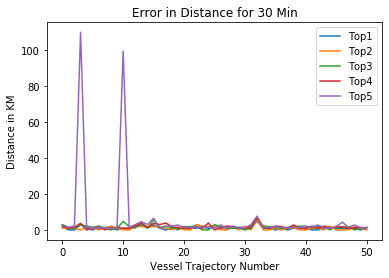

In [16]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Error in Distance for 30 Min")
ax.set_ylabel("Distance in KM")
ax.set_xlabel("Vessel Trajectory Number")
ax.plot(errorVal30_1,label = "Top1")
ax.plot(errorVal30_2,label = "Top2")
ax.plot(errorVal30_3,label = "Top3")
ax.plot(errorVal30_4,label = "Top4")
ax.plot(errorVal30_5,label = "Top5")
ax.legend()
fig.savefig('ErrorIn30Min.png')

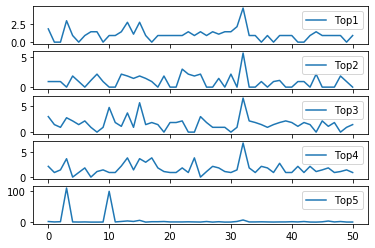

In [27]:
fig,ax = plt.subplots(5,1)
# ax.set_title("Error in Distance for 30 Min")
# ax.set_ylabel("Distance in KM")
# ax.set_xlabel("Vessel Trajectory Number")
ax[0].plot(errorVal30_1,label = "Top1")
ax[0].legend()
ax[1].plot(errorVal30_2,label = "Top2")
ax[1].legend()
ax[2].plot(errorVal30_3,label = "Top3")
ax[2].legend()
ax[3].plot(errorVal30_4,label = "Top4")
ax[3].legend()
ax[4].plot(errorVal30_5,label = "Top5")
ax[4].legend()
fig.savefig('ErrorIn30MinSub.png')

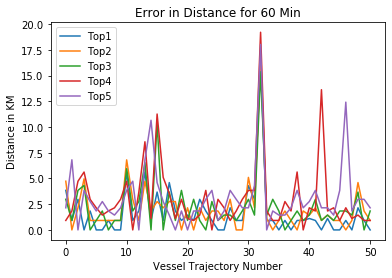

In [17]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Error in Distance for 60 Min")
ax.set_ylabel("Distance in KM")
ax.set_xlabel("Vessel Trajectory Number")
ax.plot(errorVal60_1,label = "Top1")
ax.plot(errorVal60_2,label = "Top2")
ax.plot(errorVal60_3,label = "Top3")
ax.plot(errorVal60_4,label = "Top4")
ax.plot(errorVal60_5,label = "Top5")
ax.legend()
fig.savefig('ErrorIn60Min.png')

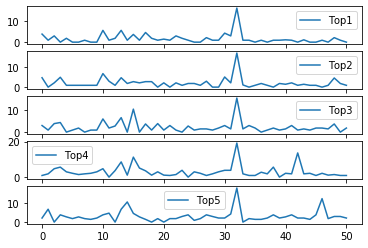

In [28]:
fig,ax = plt.subplots(5,1)
# ax.set_title("Error in Distance for 30 Min")
# ax.set_ylabel("Distance in KM")
# ax.set_xlabel("Vessel Trajectory Number")
ax[0].plot(errorVal60_1,label = "Top1")
ax[0].legend()
ax[1].plot(errorVal60_2,label = "Top2")
ax[1].legend()
ax[2].plot(errorVal60_3,label = "Top3")
ax[2].legend()
ax[3].plot(errorVal60_4,label = "Top4")
ax[3].legend()
ax[4].plot(errorVal60_5,label = "Top5")
ax[4].legend()
fig.savefig('ErrorIn60MinSub.png')

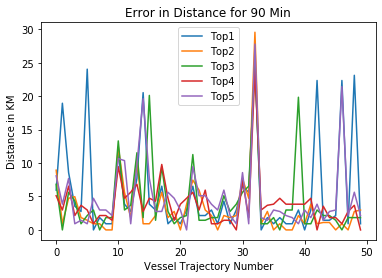

In [18]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Error in Distance for 90 Min")
ax.set_ylabel("Distance in KM")
ax.set_xlabel("Vessel Trajectory Number")
ax.plot(errorVal90_1,label = "Top1")
ax.plot(errorVal90_2,label = "Top2")
ax.plot(errorVal90_3,label = "Top3")
ax.plot(errorVal90_4,label = "Top4")
ax.plot(errorVal90_5,label = "Top5")
ax.legend()
fig.savefig('ErrorIn90Min.png')

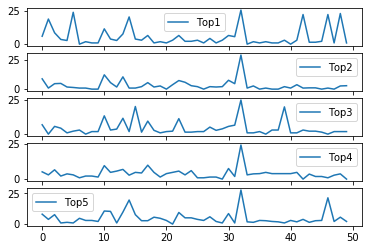

In [29]:
fig,ax = plt.subplots(5,1)
# ax.set_title("Error in Distance for 30 Min")
# ax.set_ylabel("Distance in KM")
# ax.set_xlabel("Vessel Trajectory Number")
ax[0].plot(errorVal90_1,label = "Top1")
ax[0].legend()
ax[1].plot(errorVal90_2,label = "Top2")
ax[1].legend()
ax[2].plot(errorVal90_3,label = "Top3")
ax[2].legend()
ax[3].plot(errorVal90_4,label = "Top4")
ax[3].legend()
ax[4].plot(errorVal90_5,label = "Top5")
ax[4].legend()
fig.savefig('ErrorIn90MinSub.png')

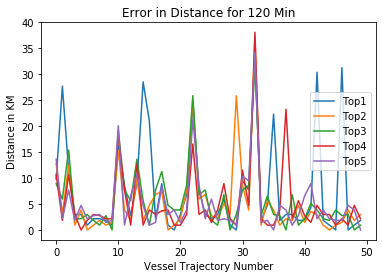

In [19]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Error in Distance for 120 Min")
ax.set_ylabel("Distance in KM")
ax.set_xlabel("Vessel Trajectory Number")
ax.plot(errorVal120_1,label = "Top1")
ax.plot(errorVal120_2,label = "Top2")
ax.plot(errorVal120_3,label = "Top3")
ax.plot(errorVal120_4,label = "Top4")
ax.plot(errorVal120_5,label = "Top5")
ax.legend()
fig.savefig('ErrorIn120Min.png')

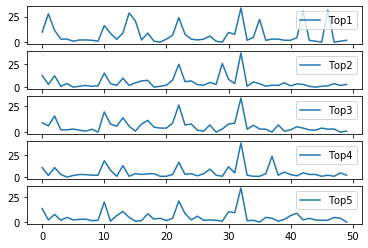

In [30]:
fig,ax = plt.subplots(5,1)
# ax.set_title("Error in Distance for 30 Min")
# ax.set_ylabel("Distance in KM")
# ax.set_xlabel("Vessel Trajectory Number")
ax[0].plot(errorVal120_1,label = "Top1")
ax[0].legend()
ax[1].plot(errorVal120_2,label = "Top2")
ax[1].legend()
ax[2].plot(errorVal120_3,label = "Top3")
ax[2].legend()
ax[3].plot(errorVal120_4,label = "Top4")
ax[3].legend()
ax[4].plot(errorVal120_5,label = "Top5")
ax[4].legend()
fig.savefig('ErrorIn120MinSub.png')

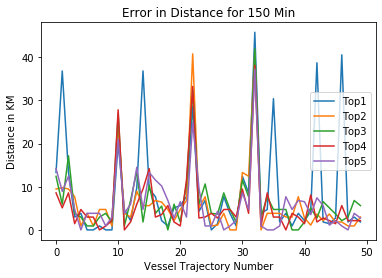

In [20]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Error in Distance for 150 Min")
ax.set_ylabel("Distance in KM")
ax.set_xlabel("Vessel Trajectory Number")
ax.plot(errorVal150_1,label = "Top1")
ax.plot(errorVal150_2,label = "Top2")
ax.plot(errorVal150_3,label = "Top3")
ax.plot(errorVal150_4,label = "Top4")
ax.plot(errorVal150_5,label = "Top5")
ax.legend()
fig.savefig('ErrorIn150Min.png')

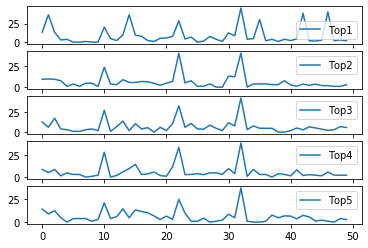

In [31]:
fig,ax = plt.subplots(5,1)
# ax.set_title("Error in Distance for 30 Min")
# ax.set_ylabel("Distance in KM")
# ax.set_xlabel("Vessel Trajectory Number")
ax[0].plot(errorVal150_1,label = "Top1")
ax[0].legend()
ax[1].plot(errorVal150_2,label = "Top2")
ax[1].legend()
ax[2].plot(errorVal150_3,label = "Top3")
ax[2].legend()
ax[3].plot(errorVal150_4,label = "Top4")
ax[3].legend()
ax[4].plot(errorVal150_5,label = "Top5")
ax[4].legend()
fig.savefig('ErrorIn150MinSub.png')

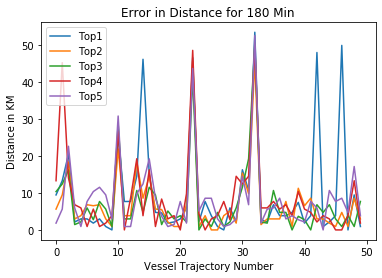

In [21]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Error in Distance for 180 Min")
ax.set_ylabel("Distance in KM")
ax.set_xlabel("Vessel Trajectory Number")
ax.plot(errorVal180_1,label = "Top1")
ax.plot(errorVal180_2,label = "Top2")
ax.plot(errorVal180_3,label = "Top3")
ax.plot(errorVal180_4,label = "Top4")
ax.plot(errorVal180_5,label = "Top5")
ax.legend()
fig.savefig('ErrorIn180Min.png')

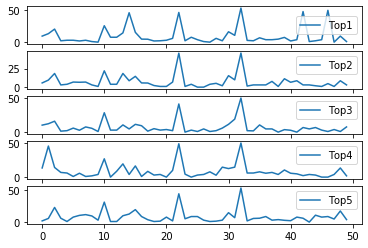

In [32]:
fig,ax = plt.subplots(5,1)
# ax.set_title("Error in Distance for 30 Min")
# ax.set_ylabel("Distance in KM")
# ax.set_xlabel("Vessel Trajectory Number")
ax[0].plot(errorVal180_1,label = "Top1")
ax[0].legend()
ax[1].plot(errorVal180_2,label = "Top2")
ax[1].legend()
ax[2].plot(errorVal180_3,label = "Top3")
ax[2].legend()
ax[3].plot(errorVal180_4,label = "Top4")
ax[3].legend()
ax[4].plot(errorVal180_5,label = "Top5")
ax[4].legend()
fig.savefig('ErrorIn180MinSub.png')

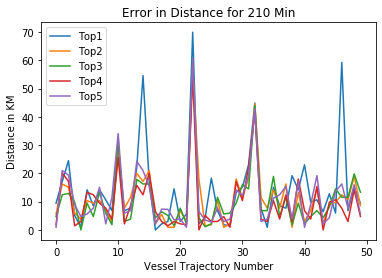

In [22]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Error in Distance for 210 Min")
ax.set_ylabel("Distance in KM")
ax.set_xlabel("Vessel Trajectory Number")
ax.plot(errorVal210_1,label = "Top1")
ax.plot(errorVal210_2,label = "Top2")
ax.plot(errorVal210_3,label = "Top3")
ax.plot(errorVal210_4,label = "Top4")
ax.plot(errorVal210_5,label = "Top5")
ax.legend()
fig.savefig('ErrorIn210Min.png')

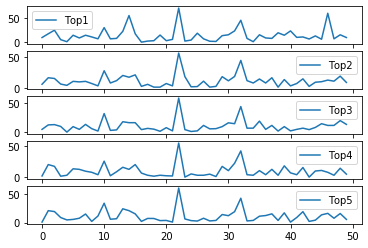

In [33]:
fig,ax = plt.subplots(5,1)
# ax.set_title("Error in Distance for 30 Min")
# ax.set_ylabel("Distance in KM")
# ax.set_xlabel("Vessel Trajectory Number")
ax[0].plot(errorVal210_1,label = "Top1")
ax[0].legend()
ax[1].plot(errorVal210_2,label = "Top2")
ax[1].legend()
ax[2].plot(errorVal210_3,label = "Top3")
ax[2].legend()
ax[3].plot(errorVal210_4,label = "Top4")
ax[3].legend()
ax[4].plot(errorVal210_5,label = "Top5")
ax[4].legend()
fig.savefig('ErrorIn210MinSub.png')

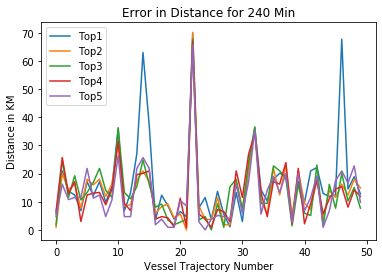

In [23]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_title("Error in Distance for 240 Min")
ax.set_ylabel("Distance in KM")
ax.set_xlabel("Vessel Trajectory Number")
ax.plot(errorVal240_1,label = "Top1")
ax.plot(errorVal240_2,label = "Top2")
ax.plot(errorVal240_3,label = "Top3")
ax.plot(errorVal240_4,label = "Top4")
ax.plot(errorVal240_5,label = "Top5")
ax.legend()
fig.savefig('ErrorIn240Min.png')

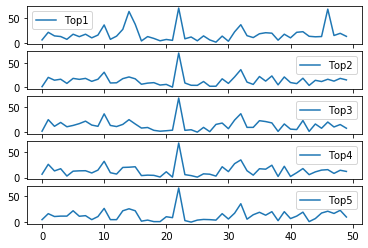

In [34]:
fig,ax = plt.subplots(5,1)
# ax.set_title("Error in Distance for 30 Min")
# ax.set_ylabel("Distance in KM")
# ax.set_xlabel("Vessel Trajectory Number")
ax[0].plot(errorVal240_1,label = "Top1")
ax[0].legend()
ax[1].plot(errorVal240_2,label = "Top2")
ax[1].legend()
ax[2].plot(errorVal240_3,label = "Top3")
ax[2].legend()
ax[3].plot(errorVal240_4,label = "Top4")
ax[3].legend()
ax[4].plot(errorVal240_5,label = "Top5")
ax[4].legend()
fig.savefig('ErrorIn240MinSub.png')

In [ ]:
errorValNP = np.array(errorVal)
print(np.mean(errorValNP))